# Pneumonia Classifier - CNN

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

2023-09-27 19:06:54.114890: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-27 19:06:54.114930: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-27 19:06:54.114956: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-27 19:06:54.121299: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 19:06:54.906920: W tensorflow/compiler/

TensorFlow version: 2.14.0


In [2]:
# Check if physical GPU device detected
gpu_devices = tf.config.list_physical_devices('GPU')
if not len(gpu_devices):
    print('No GPUs detected!')
else:
    print(len(gpu_devices), 'GPUs found!')
    print(gpu_devices)

1 GPUs found!
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-09-27 19:06:55.590694: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-27 19:06:55.614287: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-27 19:06:55.614550: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
# Setup Environment
dataset_base_dir = '../Dataset/chest_xray_resized/'
train_data_dir = 'train'
valid_data_dir = 'valid'
test_data_dir = 'test'
models_dir = './models'

In [27]:
# Image Data Generators

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_datagen = image_gen = ImageDataGenerator(
#                                rotation_range=40, # rotate the image 20 degrees
#                                width_shift_range=0.10, # Shift the pic width by a max of 5%
#                                height_shift_range=0.10, # Shift the pic height by a max of 5%
#                                rescale=1./255, # Rescale the image by normalzing it.
#                                horizontal_flip=True, # Allo horizontal flipping
#                                fill_mode='nearest' # Fill in missing pixels with the nearest filled value
#                               )

# test_datagen = image_gen = ImageDataGenerator(
#                                rotation_range=40, # rotate the image 20 degrees
#                                width_shift_range=0.10, # Shift the pic width by a max of 5%
#                                height_shift_range=0.10, # Shift the pic height by a max of 5%
#                                rescale=1./255, # Rescale the image by normalzing it.
#                                horizontal_flip=True, # Allo horizontal flipping
#                                fill_mode='nearest' # Fill in missing pixels with the nearest filled value
#                               )


train_datagen = image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.05, # Shift the pic width by a max of 5%
                               height_shift_range=0.05, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

test_datagen = image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.05, # Shift the pic width by a max of 5%
                               height_shift_range=0.05, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

image_shape = (224, 224, 3)
batch_size = 32

In [28]:
# Data Flow with Augmentation

train_gen = train_datagen.flow_from_directory(
    os.path.join(dataset_base_dir, train_data_dir),
    target_size=image_shape[:2],
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = test_datagen.flow_from_directory(
    os.path.join(dataset_base_dir, valid_data_dir), 
    target_size=image_shape[:2], 
    class_mode='binary', 
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(dataset_base_dir, test_data_dir), 
    target_size=image_shape[:2],
    class_mode='binary', 
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [29]:
# Train Dataset Stats - IMBALANCED (DUE TO MEDICAL)
from collections import Counter
counter = Counter(train_gen.classes)
print(counter.items())

dict_items([(0, 1341), (1, 3875)])


In [30]:
# Validation Dataset Stats - BALANCED
from collections import Counter
counter = Counter(valid_gen.classes)
print(counter.items())

dict_items([(0, 8), (1, 8)])


In [31]:
# Test Dataset Stats - BALANCED
from collections import Counter
counter = Counter(test_gen.classes)
print(counter.items())

dict_items([(0, 234), (1, 390)])


In [32]:
# Architect Model

from tensorflow.keras.models import  Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Activation

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3),input_shape=image_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.3))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=2, mode='auto')
checkpoint = ModelCheckpoint(filepath='./models/cnnnew_bestcheckpoint.h5', monitor='accuracy', save_best_only=True)
# learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1)

history = model.fit(train_gen, epochs=15,
          validation_data=test_gen,
          callbacks=[early_stop, checkpoint])

Epoch 1/15
163/163 [==============================] - 42s 247ms/step - loss: 0.3973 - accuracy: 0.8230 - val_loss: 0.5010 - val_accuracy: 0.7853
Epoch 2/15
163/163 [==============================] - 40s 243ms/step - loss: 0.2298 - accuracy: 0.9103 - val_loss: 0.5477 - val_accuracy: 0.8029
Epoch 3/15
163/163 [==============================] - 40s 247ms/step - loss: 0.1909 - accuracy: 0.9256 - val_loss: 0.5089 - val_accuracy: 0.8221


In [34]:
# Save trained model weights
model.save(os.path.join(models_dir, 'cnnnew_pre.h5'))

In [35]:
# Evaluate the trained model
model.load_weights('./models/cnnnew_bestcheckpoint.h5')
eval_results = model.evaluate(test_gen)

20/20 [==============================] - 4s 211ms/step - loss: 0.4690 - accuracy: 0.8301


In [36]:
# List the classes
test_gen.class_indices

{'normal': 0, 'pneumonia': 1}

In [37]:
# Take predictions using test image generator
test_dataset_prediction_probabilities = model.predict(test_gen)

20/20 [==============================] - 4s 212ms/step


In [38]:
# Argmax of Probabilities
test_dataset_predictions = [i > 0.5 for i in test_dataset_prediction_probabilities]
print(test_dataset_predictions)

[array([False]), array([False]), array([ True]), array([ True]), array([False]), array([False]), array([False]), array([False]), array([False]), array([ True]), array([ True]), array([False]), array([False]), array([False]), array([ True]), array([False]), array([ True]), array([False]), array([False]), array([False]), array([ True]), array([False]), array([False]), array([False]), array([ True]), array([ True]), array([ True]), array([False]), array([ True]), array([False]), array([False]), array([ True]), array([False]), array([False]), array([ True]), array([False]), array([False]), array([ True]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([ True]), array([ True]), array([ True]), array([ True]), array([ True]), array([ True]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([ True]), array([False]), array([False]), array([False]), array([False]), array([ True]), array([

In [39]:
# Generate classification report
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(test_gen.classes,test_dataset_predictions))

              precision    recall  f1-score   support

           0       0.92      0.65      0.76       234
           1       0.82      0.97      0.89       390

    accuracy                           0.85       624
   macro avg       0.87      0.81      0.83       624
weighted avg       0.86      0.85      0.84       624



array([[152,  82],
       [ 13, 377]])

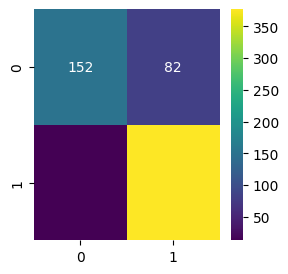

In [40]:
# Generate confusion matrix
plt.figure(figsize=(3,3))
sns.heatmap(confusion_matrix(test_gen.classes,test_dataset_predictions),annot = True, fmt = "d", cmap = "viridis")
confusion_matrix(test_gen.classes,test_dataset_predictions)

In [ ]:
# Manual Testing - Normal
from tensorflow.keras.preprocessing import image
normal_image = image.load_img('../Dataset/final/test/normal/0103fadb-1663-40a6-8a9e-09d626cd2091.png', target_size=image_shape[:2])
normal_image = np.expand_dims(normal_image, axis=1)
normal_image = normal_image.reshape(image_shape)
normal_image = normal_image / 256
plt.imshow(normal_image)
prediction = model.predict(normal_image.reshape(1, 224, 224, 3))
print(prediction[0][0] > 0.5)

In [ ]:
# Manual Testing - Pneumonia
from tensorflow.keras.preprocessing import image
positive_image = image.load_img('../Dataset/final/test/pneumonia/MIDRC-RICORD-1C-419639-000025-17477-0.png', target_size=image_shape[:2])
positive_image = np.expand_dims(positive_image, axis=1)
positive_image = positive_image.reshape(image_shape)
positive_image = positive_image / 256
plt.imshow(positive_image)
prediction = model.predict(positive_image.reshape(1, 224, 224, 3))
print(prediction[0][0] > 0.5)